In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pyspark.mllib.stat import Statistics
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

# Analyze of hashtags as a whole

The first part of our work is the analysis of how hashtags behave. Here, we want to understand the general behavior. A more precise analyse on specific hashtags will come latter.

## Creating our datasets

As the twitter dataset is huge, we can't work directly on it, we must find a way to extract insights from it that are usefull from our analysis. We are particularly interested in two metrics: 
- the count of tweets having a given hashtag
- the exposure (which we are calling "print") of tweets having a given hashtag. The exposure of a tweet is defined as an approximation of the audience reached by it, which is approximately the number of followers of the author. Then, we can approximate the exposure of several tweets by the sums of the followers of every authors. This is an over approximation as some users could have common followers, but it should be good enough.

Then, for each hashtag $h$ we are extracting the following insights:
- the total count of tweets having the hashtag $h$
- for each day the total count of tweets having the hashtag $h$ and tweeted on this day
- the exposure of tweets having the hashtag $h$
- for each day the exposure of tweets having the hashtag $h$ and tweeted on this day

More concretely, we ran the script `hashtag_insights.py` for each month on the cluster. Then, we merged the insights of different months as explained below.

### Merging of monthly insights into an insights dataframe.

We start by loading our monthly insights extracted from the cluster. We load every month of 2017 at the exception of:
- January, as we never managed to open it on the cluster
- June, as it contain nearly no data on the cluster
- December as it was absent of the cluster

In [26]:
def load_insights(months):
    return {month: spark.read.parquet('hashtags_insights_{}.parquet'.format(month)) for month in months} 

hashtags = load_insights(['02', '03', '04', '05', '07', '08', '09', '10', '11'])

For reasons we didn't understood, our hashtags insights for the month of augusts contained some duplicates rows. Hence, we remove them before continuing our analysis.

In [ ]:
hashtags['08'] = hashtags['08'].dropDuplicates()

For each monthly hashtags, some days could be absent (which is the case for the month of November where the 19th, 20th, 21st, 22nd, 23rd, 24th and 25th are missing). We remove the corresponding rows. For rows that still exists we prefix them. As rows `count` and `print` can be recomputed easily, to avoid any conflicts when joining the monthly insights we remove them.

In [ ]:
def rename_columns(insights, prefix):
    printCols = [c for c in insights.columns if "print_" in c]
    nameCols = [c for c in insights.columns if "count_" in c]
    print(insights, prefix)
    for x in printCols + nameCols:
        if insights.where(F.col(x) != 0).count() == 0:
            insights = insights.drop(x)
        else:
            insights = insights.withColumnRenamed(x, prefix + "_" + x)
    return insights.drop("count").drop("print")

In [ ]:
insights = [rename_columns(hashtags[key], key) for key in hashtags]

We now join every monthly hashtags by using an outer join.

In [ ]:
from functools import reduce

def joinAll(dfs):
    return reduce(lambda prev, cur: cur.join(prev, on='tag', how='outer'), dfs)

In [ ]:
unifiedInsights = joinAll(insights)

We then replace Nan entries by 0 and we recompute rows `count` and `print`.

In [ ]:
unifiedInsights = unifiedInsights.fillna(0).cache()
count_columns = [c for c in unifiedInsights.columns if "count" in c]
unifiedInsights = unifiedInsights.withColumn("count", sum(F.col(c) for c in count_columns))
print_columns = [c for c in unifiedInsights.columns if "print" in c]
unifiedInsights = unifiedInsights.withColumn("print", sum(F.col(c) for c in print_columns))

Finally we export this dataset to a parquet file.

In [ ]:
unifiedInsights.write.mode("overwrite").parquet("hashtags-insights.parquet")

### Building a "compressed insights" from our insights.

For convenience, we also decided to build a new dataset from the previous one. The main difference is in how we store the count per day and the print per day. In the previous dataset we had one column per day for the count and the exposure. In the one we will be building, we will have a row which will be an array of counts, and a row which will be an array of exposure (the ith entry maps to day i). These arrays will be relative to the row count and print, that is normalized between 0 and 1. This allows us to compare the behavior of two hashtags more accurately.

In [2]:
insights = spark.read.parquet("hashtags-insights.parquet")

We first build a time-sorted list of names of columns corresponding to a hashtag count. We also build the equivalent for the exposure.

In [3]:
def key(c):
    """ Parse a column name of the form month_(print|count)_day in a tuple (month, day)"""
    month, _, day = c.split("_")
    return int(month), int(day)


count_columns_wkey = [(c, key(c)) for c in insights.columns if "count_" in c]
count_columns_wkey.sort(key=lambda x: x[1])
count_columns = [a for a, _ in count_columns_wkey]
count_days = [b for _, b in count_columns_wkey]

print_columns_wkey = [(c, key(c)) for c in insights.columns if "print_" in c]
print_columns_wkey.sort(key=lambda x: x[1])
print_columns = [a for a, _ in print_columns_wkey]
print_days = [b for _, b in print_columns_wkey]

We create a new column `count_daily` which will be the array of normalized daily counts and drop the columns that have become useless.

In [ ]:
insights_compressed = \
    insights \
    .withColumn("count_daily", F.array(*[F.col(c) / F.col('count') for c in count_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in count_columns])

We know do the same to add `print_daily`, which is the equivalent of `count_daily` but for the exposure.

In [ ]:
insights_compressed = \
    insights_compressed \
    .withColumn("print_daily", F.array(*[F.col(c) / F.col('print') for c in print_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in print_columns])

Then we export the resulting dataset to a parquet file.

In [ ]:
insights_compressed.write.parquet("insights-compressed.parquet")

## Analysis of hashtags insight

We start by loading our two datasets:

In [2]:
insights = spark.read.parquet("hashtags-insights.parquet")

In [3]:
insights_compressed = spark.read.parquet("insights-compressed.parquet")

### General statistics

We have around 15 million different hashtags in the dataset.

In [32]:
insights.count()

15177260

The average exposure is of 134 thousand people, while on average an hashtag appears 21 time in our dataset. Do not forget that we extracted the hashtags from a 1% sample of twitter, hence the truth is that the true average of the number of occurences is more likely to be around 2100.

In [34]:
insights.agg({"count": "avg", "print": "avg"}).show()

+------------------+------------------+
|        avg(print)|        avg(count)|
+------------------+------------------+
|134616.39214831925|21.220559969322526|
+------------------+------------------+



However, the average count, and even the average print are completly biased by the outliers. The median of the count is 1!

In [44]:
insights.approxQuantile('count', [.25, .5, .75], .001)

[1.0, 1.0, 3.0]

In [38]:
insights.approxQuantile('print', [.25, .5, .75], .001)

[143.0, 710.0, 3968.0]

**Analyse of the distribution of the number of occurences**

In fact, only 38% of the hashtags are present more than once.

In [51]:
100 * float(insights.where(F.col('count') > 1).count()) / float(insights.count())

38.79508554244969

More surprisingly, .78% of hashtags are present at least 250 times. 

In [224]:
100 * float(insights.where(F.col('count') > 250).count()) / float(insights.count())

0.7877377075967599

Starting from now, we will pursue our analysis only on hashtags occuring more than 250 times: this a good compromise about "generality" and focusing on "viral" tweets.

In [125]:
THRESHOLD_COUNT = 250

The histogram of the number of occurences shows clearly that the number of occurences is sharply decreasing.
The noise at the start of the histogram might be due to the sampling: missing one tweet out of 50 is more impactfull than one tweet out of 250. 

In [95]:
bins, counts = insights.where(F.col('count') > 50) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

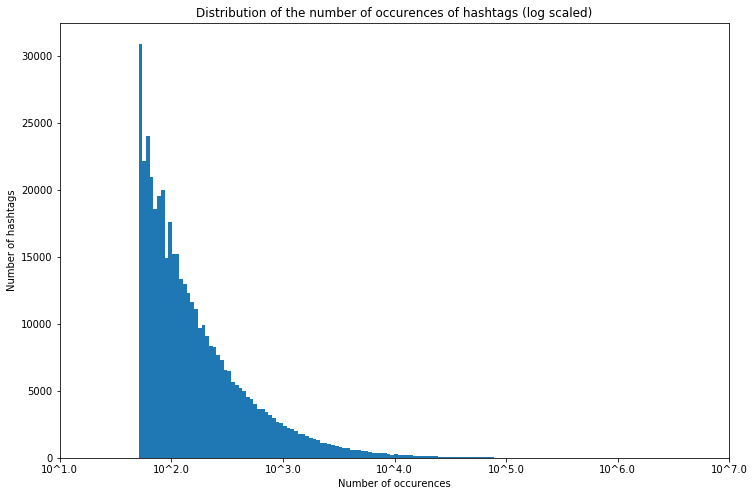

In [96]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In fact, it is even following a power-law:

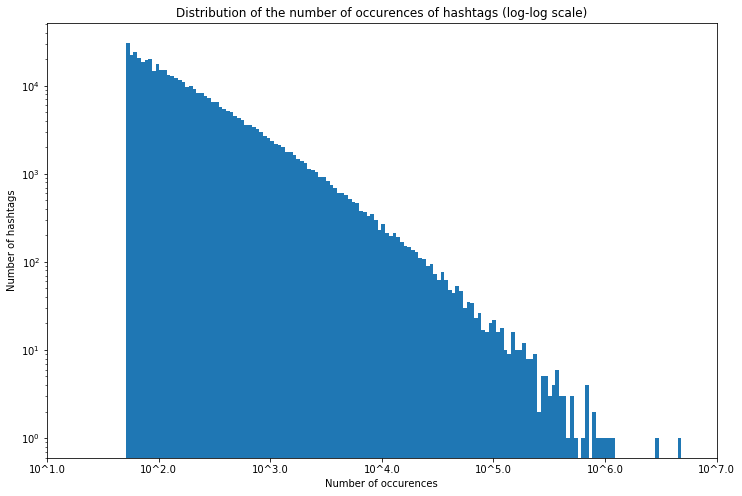

In [98]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the number of occurences of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

**Analyse of the distribution of the exposure**

Once again we plot the log distribution of the exposure. We chose to use a threshold of 250000: only 2.9% of the tweets have a bigger exposure.

In [226]:
100 * float(insights.where(F.col('print') > 250000).count()) / float(insights.count())

2.869944904416212

In [228]:
bins, counts = insights.where(F.col('print') > 250000) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

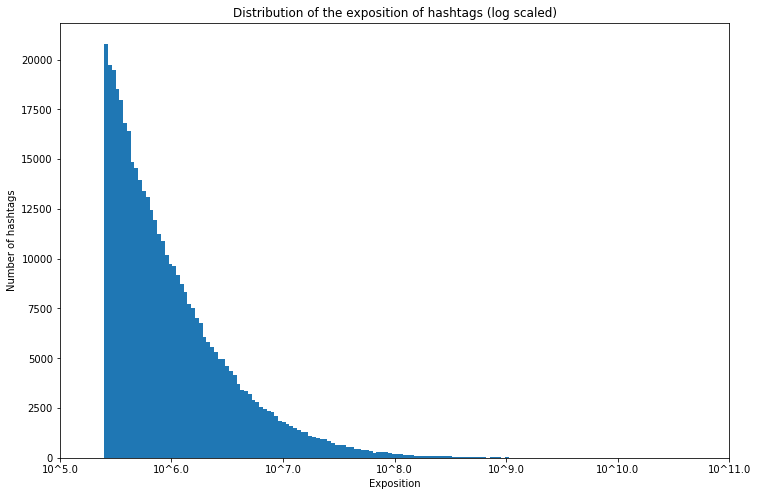

In [229]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the exposition of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Exposition')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [ ]:
Once again, we also plot the distribution on a log-log scale. 

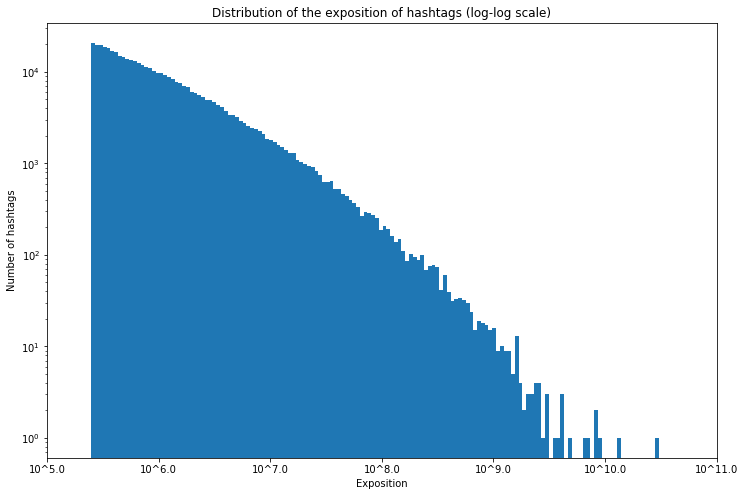

In [230]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the exposition of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Exposition')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [126]:
insights_r = insights.where(F.col('count') > THRESHOLD_COUNT).cache()

### Correlation between exposure and number of occurence.

Our intuition is that the exposure of a given hashtag, and its number of occurences are correlated. We wanted to validate this hypothesis by checking it on the dataset.

The first step is to compute spearman correlation coefficient. At 0.45, we can hope for the exposure and the number of occurences to be correlated.

In [143]:
features = insights_r.select("count", "print").rdd.map(lambda row: row[0:])
corr = Statistics.corr(features, method="spearman")

In [144]:
corr[0][1]

0.45635800425950807

However, it is always usefull to check our results visually. We first plot all points (count, print) in a scatter plot.

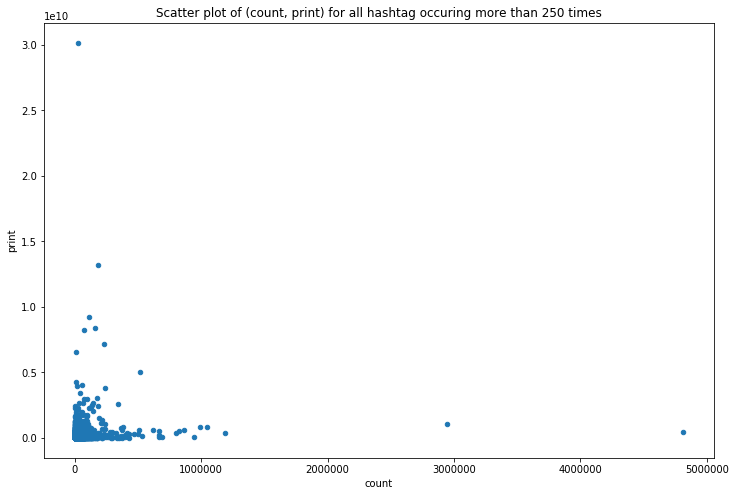

In [216]:
# the projection is small enough to fit in memory
sample = insights_r.select("tag", "count", "print").toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times');

Most of our data is in the bottom left corner. We will zoom on this corner.

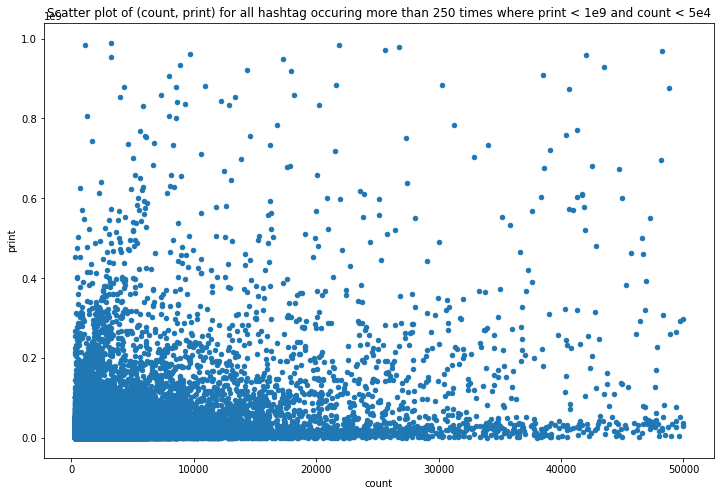

In [223]:
sample = \
    insights_r \
    .where((F.col('count') < 50000) & (F.col('print') < .1 * 1e10)) \
    .select("tag", "count", "print") \
    .toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times where print < 1e9 and count < 5e4');

Even zoomed in, we can't see a general trend. Most of the points seems to be clustered together.

We have two explanations of why we have not found a correlation between exposure and number of exposure:
- Either this correlation doesn't exists
- Either the exposure we computed is wrong. Right now it is highly dependant on who tweeted a tweet. For exemple, a user with one million follower will impact more the exposure than one thousand users with one hundred followers. However, given that users with a high number of followers are less numerous than other users, as our twitter sampled was uniformly sampled, this problem should not be present as it should have been compensated.

### Study of correlation between days

We know study the correlation of the number of tweets per day per hashtags. Intuitively, we might think that everyday has approximately the same nu

In [ ]:
We first plot the correlation matrix for the number of tweets per days

In [6]:
features = insights.where(F.col('count') > THRESHOLD_COUNT).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

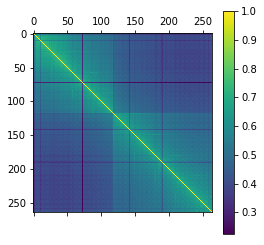

In [29]:
corr_df = pd.DataFrame(corr_mat)
ax = plt.matshow(corr_df)
plt.colorbar(ax)

In [37]:
features = insights.where(F.col('print') > 1500000).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

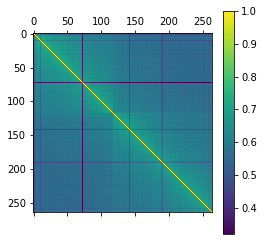

In [38]:
corr_df = pd.DataFrame(corr_mat)
ax = plt.matshow(corr_df)
plt.colorbar(ax)

In [39]:
count_days[118]

(7, 1)

In [44]:
insights.where(F.col('count') > 250).agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]).show(vertical=True)

-RECORD 0--------------
 02_count_1  | 987403  
 02_count_2  | 938978  
 02_count_3  | 249162  
 02_count_5  | 772542  
 02_count_6  | 1143028 
 02_count_7  | 1095506 
 02_count_8  | 1078792 
 02_count_9  | 1083597 
 02_count_10 | 1013434 
 02_count_11 | 1023395 
 02_count_12 | 260172  
 02_count_13 | 314072  
 02_count_14 | 1041497 
 02_count_15 | 960805  
 02_count_16 | 956833  
 02_count_17 | 1003306 
 02_count_18 | 1051258 
 02_count_19 | 1081788 
 02_count_20 | 1001810 
 02_count_21 | 1016369 
 02_count_22 | 1104950 
 02_count_23 | 1060823 
 02_count_24 | 1090663 
 02_count_25 | 1058844 
 02_count_26 | 1028391 
 02_count_27 | 1086430 
 02_count_28 | 1002684 
 03_count_1  | 942305  
 03_count_2  | 1023506 
 03_count_3  | 999595  
 03_count_4  | 1063947 
 03_count_5  | 1170305 
 03_count_6  | 1128743 
 03_count_7  | 933377  
 03_count_8  | 1061935 
 03_count_9  | 957482  
 03_count_10 | 924831  
 03_count_11 | 934168  
 03_count_12 | 1006777 
 03_count_13 | 948103  
 03_count_14 | 9

In [49]:
sum_count_day_pd = insights.where(F.col('count') > 250).agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]).toPandas()

In [58]:
sum_count_day_pd.head()

02_count_1  02_count_2  02_count_3  02_count_5  02_count_6  02_count_7  \
0      987403      938978      249162      772542     1143028     1095506   

   02_count_8  02_count_9  02_count_10  02_count_11     ...       11_count_14  \
0     1078792     1083597      1013434      1023395     ...            802890   

   11_count_15  11_count_16  11_count_17  11_count_18  11_count_26  \
0       770297       784771       758761       520248       829367   

   11_count_27  11_count_28  11_count_29  11_count_30  
0      1219880       714586       848704       683677  

[1 rows x 264 columns]

In [66]:
sum_count_day_pd.columns

Index([u'02_count_1', u'02_count_2', u'02_count_3', u'02_count_5',
       u'02_count_6', u'02_count_7', u'02_count_8', u'02_count_9',
       u'02_count_10', u'02_count_11',
       ...
       u'11_count_14', u'11_count_15', u'11_count_16', u'11_count_17',
       u'11_count_18', u'11_count_26', u'11_count_27', u'11_count_28',
       u'11_count_29', u'11_count_30'],
      dtype='object', length=264)

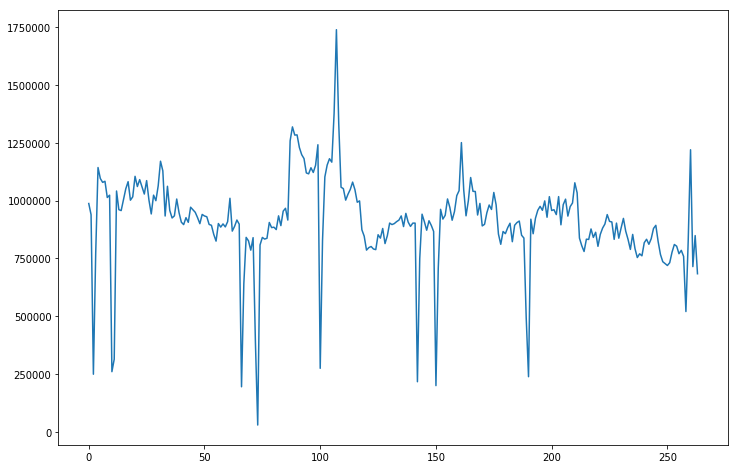

In [71]:
plt.plot( range(0, len(count_columns)), sum_count_day_pd.loc[0].values)

In [ ]:
plt.plot()

In [10]:
corr_mat=Statistics.corr(features, method="pearson")

In [12]:
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = count_columns, count_columns

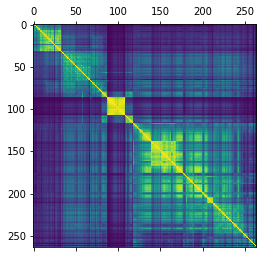

In [13]:
plt.matshow(corr_mat)

In [19]:
features = insights.where(F.col('count') > 100).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

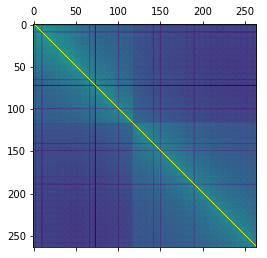

In [20]:
plt.matshow(corr_mat)

In [22]:
count_days[90:110]

[(5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (5, 19),
 (5, 20),
 (5, 21),
 (5, 22),
 (5, 23)]

In [ ]:
features = insights.where(F.col('print') > 100).select(print_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")

In [11]:
insights.count()

15177260

In [15]:
insights.where(F.col('count') > 1).count()

5888031

In [16]:
insights.where(F.col('count') > 100).count()

257434

In [17]:
bins, counts = insights.where(F.col('count') > 100) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(100)

Text(0, 0.5, 'Number of occurences')

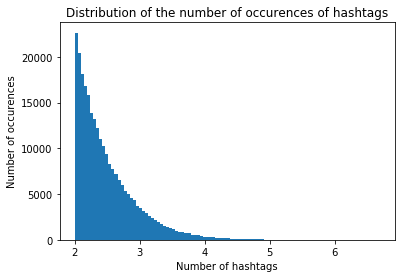

In [19]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags' )
plt.xlabel('Number of hashtags')
plt.ylabel('Number of occurences')

In [30]:
bins, counts = insights.where(F.col('print') > 1000) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(100)

Text(0, 0.5, 'Number of occurences')

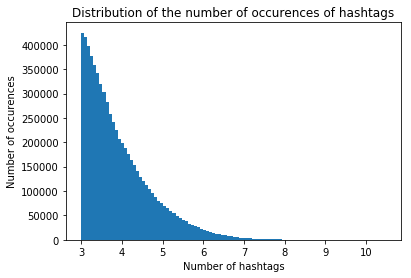

In [31]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags' )
plt.xlabel('Number of hashtags')
plt.ylabel('Number of occurences')

In [32]:
test = insights.where(F.col('count') > 100).toPandas()

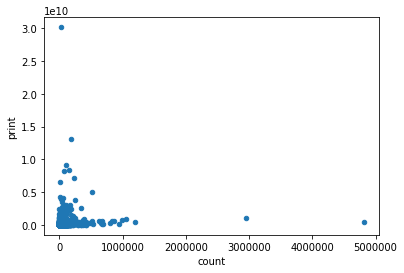

In [34]:
test.plot.scatter(x="count", y="print")

In [37]:
test.sort_values("count", ascending=False).head()

tag  11_print_1  11_print_2  11_print_3  11_print_4  \
193708  izmirescort      683095     1173665      495435      449088   
181676     BTSBBMAs      313285        8747      286921       13567   
181942   MTVHottest       48775       35054       44860       69997   
256291          BTS     4667800     2774639     6995572     4675435   
253669        방탄소년단     5333705     3708412     6501709     5048843   

        11_print_5  11_print_6  11_print_7  11_print_8  11_print_9  \
193708      605584      305955       68561       41577       66398   
181676      253865       54084       12916        4770        8963   
181942       41356       52917       29678       42271       34500   
256291     1901820     2946446     1844329     2342752     1958604   
253669     3176814     3018128     1925205     2081661     1854240   

           ...      02_count_21  02_count_22  02_count_23  02_count_24  \
193708     ...             4916         7339         5696         5451   
181676     ...                0            0            0            0   
181942     ...               89           86           99           98   
256291     ...             2632         4931         6164         5951   
253669     ...             3190         5655        11064         9037   

        02_count_25  02_count_26  02_count_27  02_count_28    count  \
193708         4886         4517         5264         6686  4813484   
181676            0            0            0            0  2943069   
181942           57           35           34           46  1188991   
256291         4760         5391         4229         2911  1048438   
253669         7407         8583         4950         3238   992185   

             print  
193708   473402849  
181676  1054566200  
181942   408684695  
256291   856258406  
253669   805900903  

[5 rows x 531 columns]

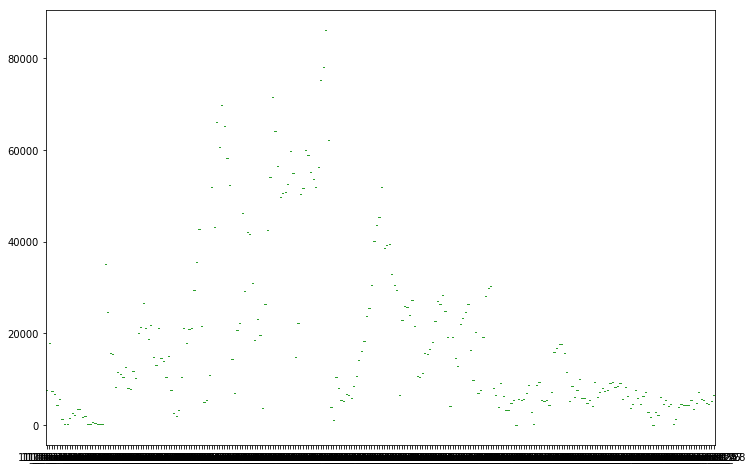

In [50]:
columns = [c for c in test.columns if "count_" in c]
test[test.tag=="izmirescort"].boxplot(columns, grid=False)

In [ ]:
insightsPd = insights.select(F.col('count') > 250).toPandas()

In [117]:
insightsPd.shape

NameError: name 'insightsPd' is not defined

In [121]:
import re
cyrillic = "[\u0400-\u04FF\u0500-\u052F]"
arabic = "[\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF]"
chinese = "[\u2E80-\u2EFF\u3000-\u303F\u3100-\u312F\u31A0-\u31BF\u31C0-\u31EF\u3200-\u32FF\u3300-\u33FF\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\uFE30-\uFE4F]"
japanese = "[\u3040-\u309F\u30A0-\u30FF\u31F0-\u31FF]"
korean = "[\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF]"
re_cyrillic = re.compile(cyrillic, re.UNICODE)
re_arabic = re.compile(arabic, re.UNICODE)
re_chinese = re.compile(chinese, re.UNICODE)
re_japanese = re.compile(japanese, re.UNICODE)
re_korean = re.compile(korean, re.UNICODE)



def approximateCountry(tag):
    if re_cyrillic.search(tag) is not None:
        return "cyrillic"
    elif re_arabic.search(tag) is not None:
        return "arabic"
    elif re_chinese.search(tag) is not None:
        return "chinese"
    elif re_japanese.search(tag) is not None:
        return "japanese"
    elif re_korean.search(tag) is not None:
        return "korean"
    else:
        return "latin"
    
udfapproximateCountry = F.udf(approximateCountry, StringType())

In [127]:
insights_alphabet = insights_r.withColumn("alphabet", udfapproximateCountry(F.col('tag')))

In [131]:
foo = insights_alphabet.groupby('alphabet').agg(F.count(F.lit(1)).alias('count')).toPandas()

In [172]:
foo.set_index('alphabet').T

alphabet  korean  cyrillic  chinese  arabic  japanese  latin
count      11157       571    11643   14870      4741  76575

In [210]:
language_df = pd.DataFrame()
thresholds = list(range(250, 25001, 250))#[250, 500, 1000, 5000, 10000, 25000]
for t in thresholds:
    filtered = \
        insights_alphabet \
        .where(F.col('count') > t) 
    count = filtered.count()
    temp = \
        filtered \
        .groupby('alphabet') \
        .agg((F.count(F.lit(1)) / count).alias('count_' + str(t))) \
        .toPandas()
    language_df = pd.concat([language_df, temp.set_index('alphabet').T], ignore_index=True, sort=True)

In [211]:
language_df = language_df.fillna(0)
language_df['threshold'] = thresholds

In [212]:
language_df

arabic   chinese  cyrillic  japanese    korean     latin  threshold
0   0.124376  0.097385  0.004776  0.039655  0.093320  0.640489        250
1   0.121645  0.096241  0.003682  0.040533  0.098444  0.639455        500
2   0.117787  0.094991  0.003404  0.039747  0.099984  0.644087        750
3   0.110879  0.093390  0.002944  0.039982  0.102665  0.650140       1000
4   0.104368  0.092280  0.002666  0.040060  0.105280  0.655346       1250
5   0.097511  0.092786  0.002537  0.040553  0.108010  0.658603       1500
6   0.092842  0.091969  0.002105  0.039283  0.107887  0.665914       1750
7   0.089669  0.090492  0.002293  0.038278  0.108426  0.670841       2000
8   0.086007  0.089735  0.002263  0.037745  0.108374  0.675875       2250
9   0.084886  0.087178  0.001923  0.038376  0.108400  0.679237       2500
10  0.083770  0.085406  0.001882  0.038940  0.108966  0.681037       2750
11  0.082066  0.085824  0.001521  0.039467  0.108735  0.682388       3000
12  0.080070  0.083772  0.001266  0.040230  0.109390  0.685272       3250
13  0.077840  0.083114  0.001371  0.040080  0.109904  0.687691       3500
14  0.076356  0.082029  0.001361  0.040277  0.111073  0.688904       3750
15  0.073872  0.081756  0.001213  0.040150  0.113901  0.689107       4000
16  0.073649  0.080872  0.001290  0.040500  0.114149  0.689540       4250
17  0.072889  0.079753  0.001373  0.040631  0.116129  0.689224       4500
18  0.072891  0.080151  0.001452  0.040366  0.117613  0.687527       4750
19  0.072736  0.079963  0.001230  0.039982  0.118714  0.687375       5000
20  0.071835  0.081099  0.000975  0.039168  0.120917  0.686007       5250
21  0.071490  0.080703  0.000853  0.039413  0.122675  0.684866       5500
22  0.071480  0.080079  0.000896  0.039054  0.123791  0.684701       5750
23  0.072291  0.079275  0.000944  0.039449  0.123632  0.684409       6000
24  0.073050  0.078776  0.000987  0.039289  0.124975  0.682922       6250
25  0.072104  0.078677  0.001027  0.039236  0.125924  0.683032       6500
26  0.072832  0.077745  0.001068  0.038018  0.126869  0.683469       6750
27  0.071952  0.076838  0.001110  0.038641  0.128359  0.683100       7000
28  0.072929  0.077083  0.001154  0.038541  0.128548  0.681745       7250
29  0.072162  0.076941  0.001195  0.038710  0.129271  0.681720       7500
..       ...       ...       ...       ...       ...       ...        ...
70  0.066121  0.063602  0.000630  0.032116  0.146725  0.690806      17750
71  0.064061  0.064061  0.000641  0.032671  0.146701  0.691864      18000
72  0.064453  0.063802  0.000651  0.033203  0.147135  0.690755      18250
73  0.065116  0.063123  0.000664  0.033223  0.148837  0.689037      18500
74  0.065674  0.063643  0.000677  0.033175  0.147596  0.689235      18750
75  0.066575  0.063143  0.000686  0.033631  0.146877  0.689087      19000
76  0.066341  0.061453  0.000698  0.032821  0.145251  0.693436      19250
77  0.066525  0.059448  0.000708  0.033263  0.145789  0.694268      19500
78  0.065808  0.059371  0.000715  0.032904  0.144492  0.696710      19750
79  0.065598  0.058309  0.000729  0.032070  0.144315  0.698980      20000
80  0.065574  0.058867  0.000745  0.032787  0.146051  0.695976      20250
81  0.065004  0.058957  0.000756  0.033258  0.147392  0.694633      20500
82  0.063407  0.058824  0.000764  0.032086  0.148969  0.695951      20750
83  0.062693  0.058050  0.000774  0.031734  0.150155  0.696594      21000
84  0.061273  0.058130  0.000786  0.032207  0.150039  0.697565      21250
85  0.061502  0.055911  0.000799  0.031949  0.150958  0.698882      21500
86  0.060877  0.055195  0.000812  0.031656  0.151786  0.699675      21750
87  0.060606  0.055692  0.000819  0.031941  0.149877  0.701065      22000
88  0.060231  0.055281  0.000825  0.032178  0.150990  0.700495      22250
89  0.060555  0.054668  0.000841  0.032801  0.150547  0.700589      22500
90  0.059625  0.055366  0.000852  0.033220  0.151618  0.699319      22750
91  0.057858  0.053541  0.000864  0.033679  0.151986  0.702073      23000
92  0.0576

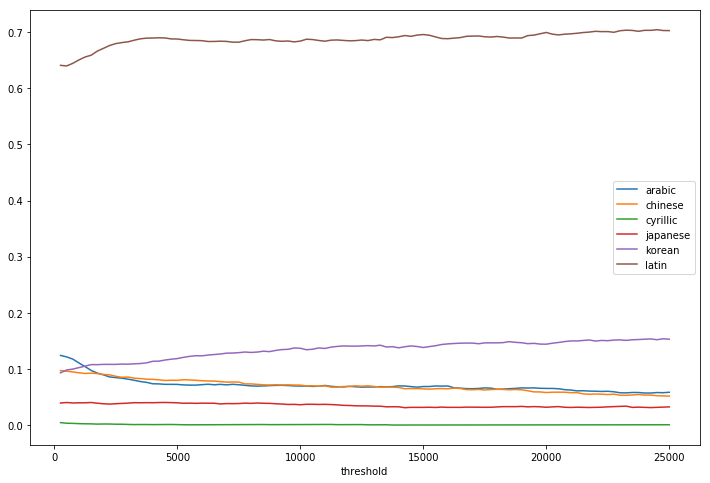

In [213]:
language_df.plot(x='threshold', y=[col for col in language_df.columns if col != 'threshold'])

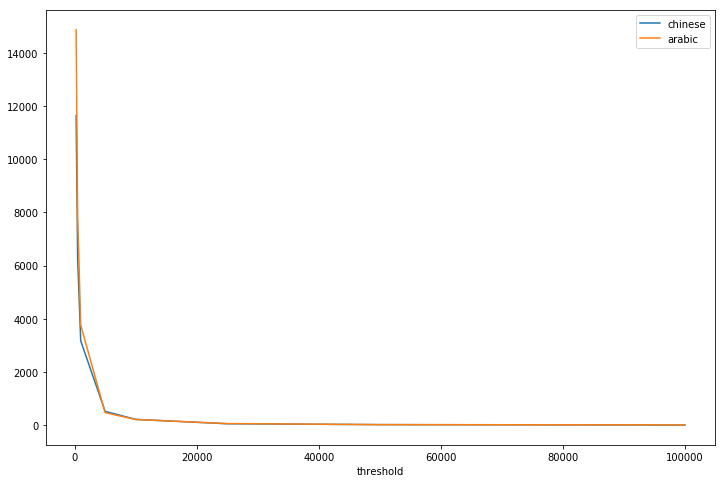

In [199]:
language_df.plot(x='threshold', y=["chinese", "arabic"])

In [47]:
sample_ic_pd = insights_compressed.where(F.col('count') > 250).sample(False, .005).toPandas()

In [48]:
sample_ic_pd.shape

(575, 5)

In [57]:
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw

In [155]:
values = sample_ic_pd.count_daily.map(lambda x: (np.array(x) - np.mean(x)) / np.std(x)).values

In [156]:
values

array([array([-0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864

In [157]:
dist_matrix =\
    squareform(pdist(
        pd.DataFrame(values.tolist(), index=sample_ic_pd.index), 
        lambda a, b : fastdtw(a, b)[0]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
dist_matrix

array([[  0.        ,  41.36908777, 209.62624378, ...,   9.85409129,
         59.46865413,   6.65233866],
       [ 41.36908777,   0.        , 202.8198814 , ...,   7.46074803,
         89.00718744,  40.94033065],
       [209.62624378, 202.8198814 ,   0.        , ..., 203.5014087 ,
        204.27005096, 206.95405966],
       ...,
       [  9.85409129,   7.46074803, 203.5014087 , ...,   0.        ,
         64.76487184,   9.19732241],
       [ 59.46865413,  89.00718744, 204.27005096, ...,  64.76487184,
          0.        ,  64.43046609],
       [  6.65233866,  40.94033065, 206.95405966, ...,   9.19732241,
         64.43046609,   0.        ]])

In [168]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'precomputed', linkage = 'average')
    labels = model.fit_predict(X)
    return labels

labels = doAgglomerative(dist_matrix, 10)

In [160]:
labels

array([3, 3, 9, 3, 2, 3, 3, 8, 3, 3, 3, 3, 4, 5, 3, 1, 8, 8, 3, 3, 5, 3,
       3, 3, 4, 4, 0, 0, 3, 8, 3, 3, 3, 6, 5, 8, 9, 0, 3, 3, 1, 3, 3, 8,
       6, 3, 3, 3, 3, 3, 9, 7, 3, 3, 5, 1, 3, 3, 9, 1, 7, 3, 0, 3, 7, 3,
       3, 7, 0, 3, 3, 3, 3, 7, 4, 8, 1, 9, 3, 3, 3, 2, 3, 3, 7, 3, 3, 3,
       2, 3, 4, 3, 3, 3, 3, 3, 7, 6, 0, 2, 3, 7, 6, 3, 0, 3, 1, 3, 3, 0,
       3, 3, 8, 2, 3, 3, 3, 3, 0, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 8,
       8, 3, 3, 3, 3, 5, 3, 3, 3, 2, 3, 6, 2, 3, 3, 3, 1, 6, 6, 3, 3, 3,
       3, 3, 7, 3, 3, 0, 7, 3, 3, 4, 8, 3, 3, 3, 3, 1, 7, 3, 3, 4, 5, 2,
       0, 3, 3, 0, 3, 1, 3, 7, 9, 7, 7, 3, 3, 3, 8, 2, 0, 3, 8, 0, 3, 3,
       8, 1, 6, 3, 4, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 7, 3, 3, 8,
       4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 7, 3, 8, 3, 7, 3, 3,
       8, 3, 3, 3, 3, 7, 1, 8, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 3, 1, 0, 3,
       3, 7, 4, 8, 3, 4, 7, 3, 9, 8, 3, 0, 1, 3, 0, 3, 8, 0, 3, 3, 0, 3,
       9, 3, 7, 3, 3, 1, 3, 3, 9, 3, 3, 3, 1, 3, 3,

/home/pierre/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


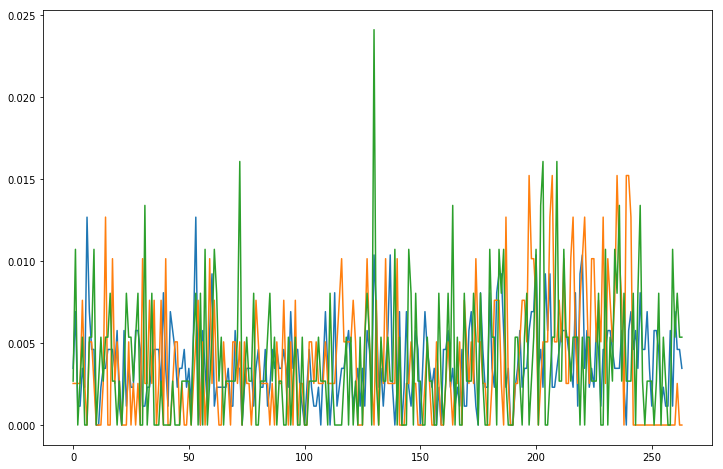

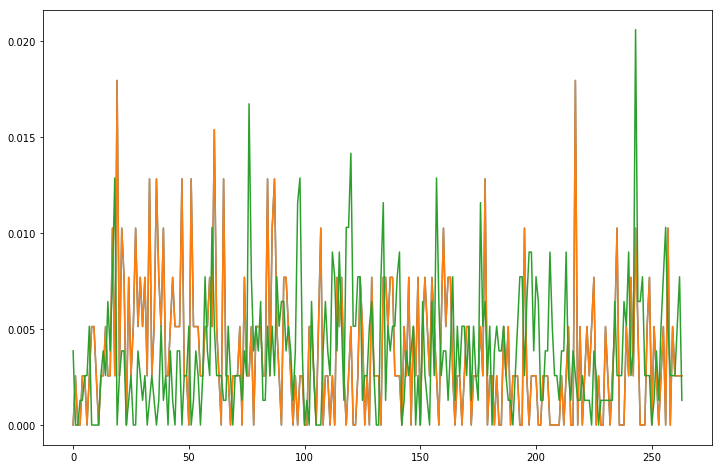

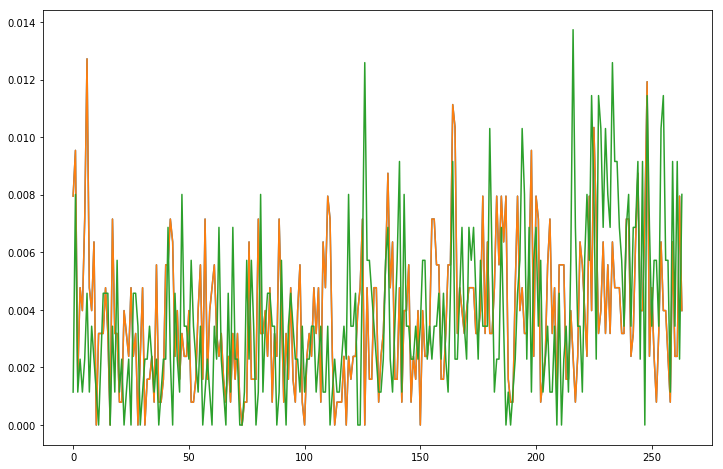

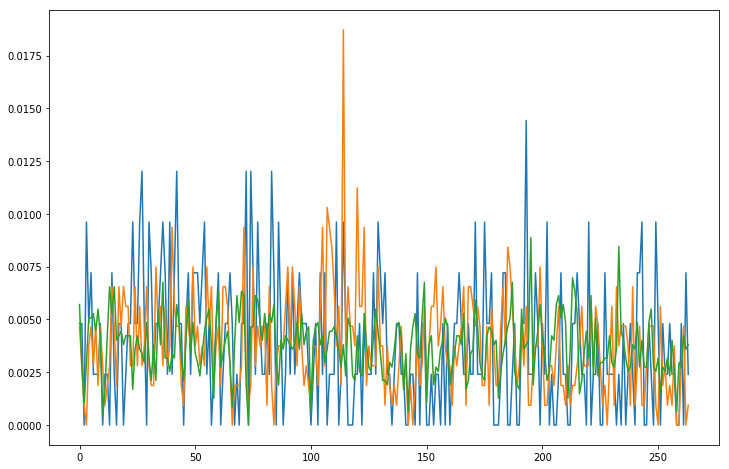

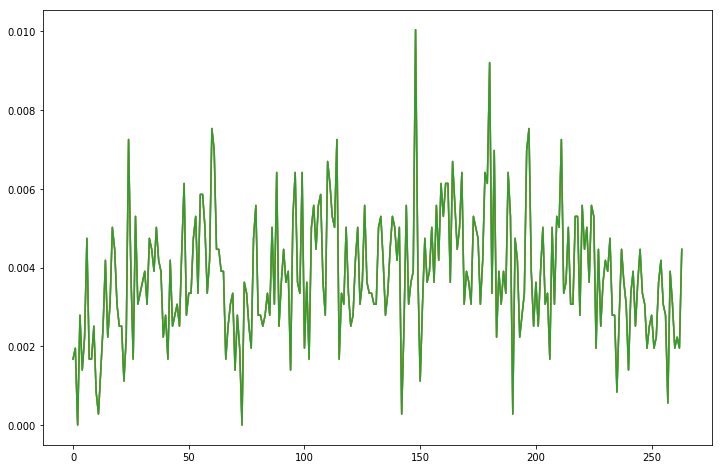

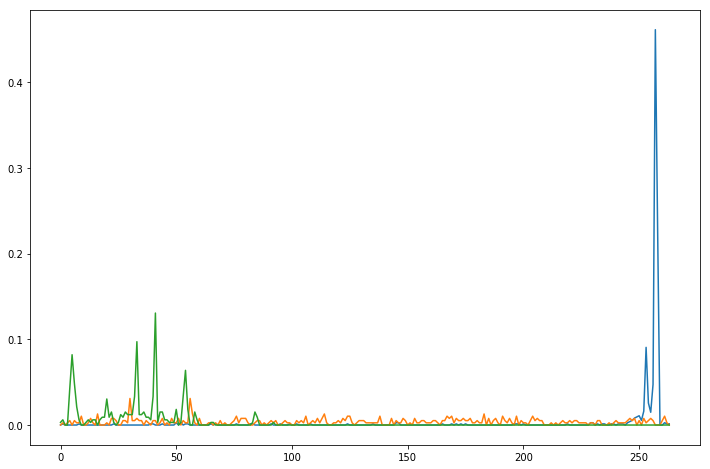

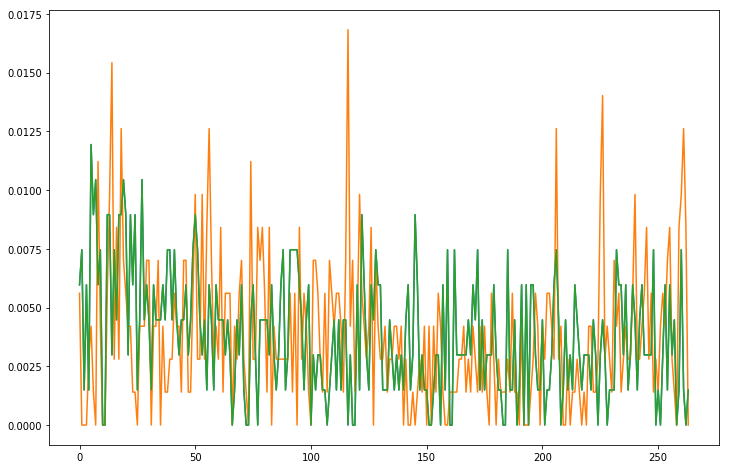

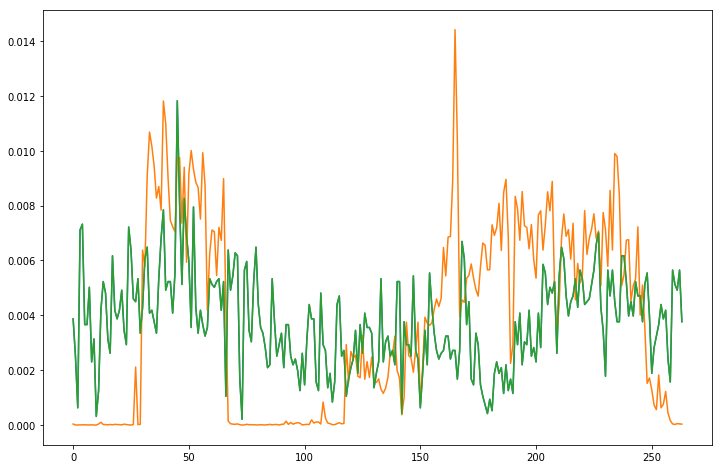

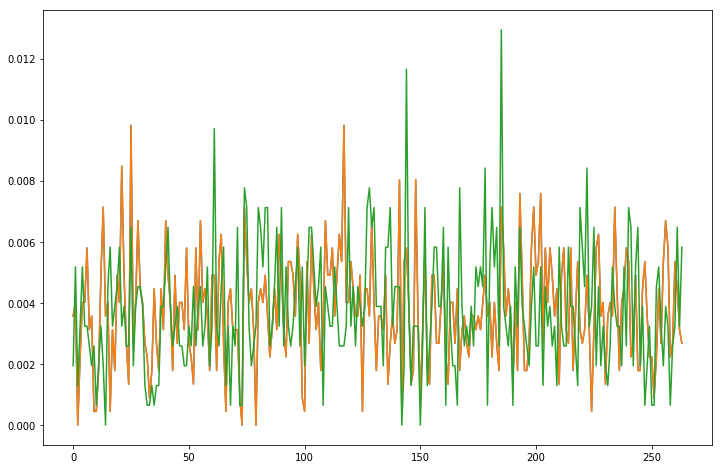

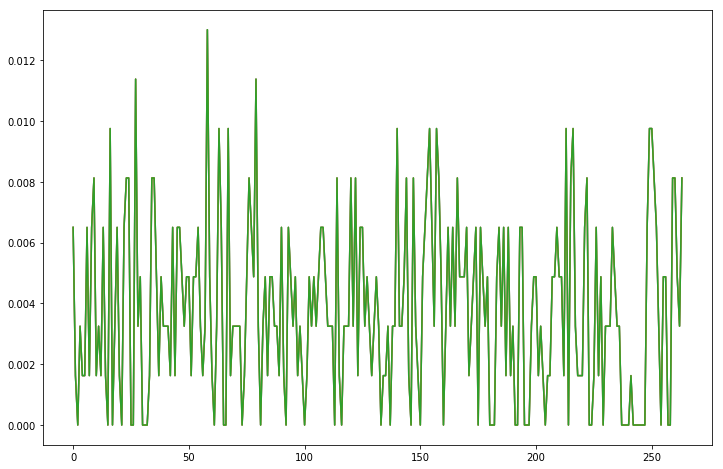

In [169]:
labeled_sample = sample_ic_pd
labeled_sample["label"] = labels
for i in range(len(set(labels))):
    plt.figure(figsize=(12, 8))
    #plt.ylim(0, 1)
    which = labeled_sample.label == i
    labeled_sample[which].sample(n=3, replace=True).count_daily.map(lambda r: pd.Series(r).plot())

In [ ]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    return clust_labels

clust_labels = doKmeans(wh1, 5)
kmeans = pd.DataFrame(clust_labels)